# Calculate Arctic total ice area from LESSMELT experiments

* **Description**: Reads in and creates regional integrated values from less melt tuned albedo experiment
* **Creator**: Alice DuVivier
* **Date**: March 2025

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec

## Load mask file for getting area totals

In [2]:
# Grid
ds_grid = xr.open_dataset('/glade/u/home/duvivier/masks/ocn_grid_gx1v7.nc',decode_times=False)

# Get lat and lon
TLAT = ds_grid['TLAT']
TLONG = ds_grid['TLONG']

# rename some coordinates so things work properly!
TLAT = TLAT.rename({'nlat':'nj', 'nlon':'ni'})
TLONG = TLONG.rename({'nlat':'nj', 'nlon':'ni'})

In [3]:
# Load in masks
mask_in = ['nh_mask']
ds_masks = xr.open_mfdataset('/glade/u/home/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decod

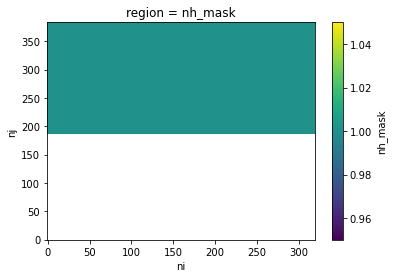

In [4]:
# verify it worked - choose one region to plot
masks.sel(region='nh_mask').plot()

## Choose the variable to process

In [5]:
# list the variables to load
var_in = 'aice'

# aice, hi

## Load lessmelt experiments

In [6]:
# Load "less melt" data - historical
#choose cases and data paths
case1 = 'b.e21.BHIST.f09_g17.CMIP6-historical.012'
case2 = 'b.e21.BHIST.f09_g17.CMIP6-historical.013'
case3 = 'b.e21.BHIST.f09_g17.CMIP6-historical.014'
case4 = 'b.e21.BHIST.f09_g17.CMIP6-historical.015'
## There are more members - 016-022, but I am only processing 4 here

# set base directory where all data live
#data_dir = '/glade/campaign/cgd/ppc/cesm2_tuned_albedo/'
data_dir = '/glade/campaign/cgd/ppc/Kayetal22/'

In [7]:
%%time
#reading in files
ds1 = []
ds2 = []
ds3 = []
ds4 = []

print("loading "+var_in)   
my_files=sorted(glob.glob(data_dir+case1+'.cice.h.'+var_in+'.*.nc'))
ds1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir+case2+'.cice.h.'+var_in+'.*.nc'))
ds2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir+case3+'.cice.h.'+var_in+'.*.nc'))
ds3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir+case4+'.cice.h.'+var_in+'.*.nc'))
ds4=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

# verify it worked - plot first time only
#ds1["aice"].isel(time=0).plot()

loading aice
CPU times: user 663 ms, sys: 94.7 ms, total: 758 ms
Wall time: 2.01 s


In [8]:
# cut first dataset at 1920 to match others
ds1 = ds1.isel(time=slice(840,1980))

In [9]:
historical = xr.concat([ds1,ds2,ds3,ds4],dim='member_id')

In [10]:
historical

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 4, time: 1140, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 1920-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 360, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 360, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 360, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 360, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHIST.f09_g17.CMIP6-historical.012
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 18500201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2019-09-10 at 13:18
    io_flavor:         io_pio

In [11]:
historical.member_id.values

# assign member_id as coordinate array
historical.assign_coords({"member_id": historical.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 4, time: 1140, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 1920-02-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 360, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 360, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 360, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 360, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHIST.f09_g17.CMIP6-historical.012
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 18500201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2019-09-10 at 13:18
    io_flavor:         io_pio

In [12]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
#historical.time_bounds.load().mean(dim='d2').sel(member_id=0)

historical.time_bounds.load().mean(dim='d2').sel(member_id=0)

<xarray.DataArray 'time_bounds' (time: 1140)>
array([cftime.DatetimeNoLeap(1920, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1920, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1920, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1920-02-01 00:00:00 ... 2015-01-01 00:00:00

In [13]:
historical['time'] = historical.time_bounds.load().mean(dim='d2').sel(member_id=0)

In [14]:
# Load "less melt" data - future
#choose cases and data paths
case1 = 'b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.112'
case2 = 'b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.113'
case3 = 'b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.114'
case4 = 'b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.115'

# set base directory where all data live
#data_dir = '/glade/campaign/cgd/ppc/cesm2_tuned_albedo/'
data_dir = '/glade/campaign/cgd/ppc/Kayetal22/'

In [15]:
%%time
#reading in files
ds1 = []
ds2 = []
ds3 = []
ds4 = []

print("loading "+var_in)   
my_files=sorted(glob.glob(data_dir+case1+'.cice.h.'+var_in+'.*.nc'))
ds1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir+case2+'.cice.h.'+var_in+'.*.nc'))
ds2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir+case3+'.cice.h.'+var_in+'.*.nc'))
ds3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir+case4+'.cice.h.'+var_in+'.*.nc'))
ds4=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

# verify it worked - plot first time only
#ds1["aice"].isel(time=0).plot()

loading aice
CPU times: user 649 ms, sys: 88.6 ms, total: 738 ms
Wall time: 1.68 s


In [16]:
futures = xr.concat([ds1,ds2,ds3,ds4],dim='member_id')

In [17]:
futures.member_id.values

# assign member_id as coordinate array
futures.assign_coords({"member_id": futures.member_id.values})

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 4, time: 1020, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 2015-02-01 00:00:00 ... 2100-01-01 00:00:00
  * member_id    (member_id) int64 0 1 2 3
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 600, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 600, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 600, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 600, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(1, 600, 2), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 600, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0.112
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20150201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2020-04-28 at 16:18
    io_flavor:         io_pio

In [18]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures.time_bounds.load().mean(dim='d2').sel(member_id=0)

<xarray.DataArray 'time_bounds' (time: 1020)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2099, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2100-01-01 00:00:00

In [19]:
futures['time'] = futures.time_bounds.load().mean(dim='d2').sel(member_id=0)

In [20]:
futures.time

<xarray.DataArray 'time' (time: 1020)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2099, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00

In [21]:
# concatenate into one dataset
data_all = xr.concat([historical,futures],dim='time')

In [24]:
data_all

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 4, time: 2160, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT         (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    ULON         (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT         (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan
  * time         (time) object 1920-01-16 12:00:00 ... 2099-12-16 12:00:00
Dimensions without coordinates: nj, ni, member_id, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, time, nc) float32 dask.array<chunksize=(1, 360, 5), meta=np.ndarray>
    VGRDi        (member_id, time, nkice) float32 dask.array<chunksize=(1, 360, 8), meta=np.ndarray>
    VGRDs        (member_id, time, nksnow) float32 dask.array<chunksize=(1, 360, 3), meta=np.ndarray>
    VGRDb        (member_id, time, nkbio) float32 dask.array<chunksize=(1, 360, 5), meta=np.ndarray>
    tmask        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
    tarea        (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, time, nj, ni, nvertices) float32 dask.array<chunksize=(1, 360, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object 1920-01-01 00:00:00 ... 2100-01...
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 360, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHIST.f09_g17.CMIP6-historical.012
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 18500201
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2019-09-10 at 13:18
    io_flavor:         io_pio

## Apply masks to the dataset

In [25]:
#mask just regions to calculate total ice area and ice volumes
data_masked = data_all[var_in]*masks

In [26]:
data_masked.region

<xarray.DataArray 'region' (region: 1)>
array(['nh_mask'], dtype='<U7')
Coordinates:
  * region   (region) <U7 'nh_mask'

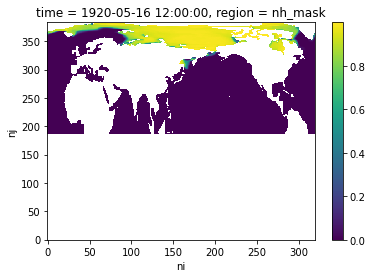

In [27]:
#just test that it worked properly
data_masked.sel(region='nh_mask').isel(member_id=0,time=4).plot()

## Calculate regional totals

Total Ice area = sum over lat/lon of (aice*tarea). Units = m2

Note that tarea is in cm^2

In [28]:
# get pop grid
grid = pop_tools.get_grid('POP_gx1v7')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [29]:
# convert tarea to m^2
tarea = grid['TAREA']/(1e4)
tarea=tarea.rename({'nlat':'nj','nlon': 'ni'})

In [30]:
# multiply the values by tarea to get total area(m2) or volume(m3) of ice
data_masked_area = data_masked*tarea

In [31]:
data_masked_area

<xarray.DataArray (member_id: 4, time: 2160, nj: 384, ni: 320, region: 1)>
dask.array<mul, shape=(4, 2160, 384, 320, 1), dtype=float64, chunksize=(1, 600, 384, 320, 1), chunktype=numpy.ndarray>
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time     (time) object 1920-01-16 12:00:00 ... 2099-12-16 12:00:00
  * region   (region) <U7 'nh_mask'
Dimensions without coordinates: member_id, nj, ni

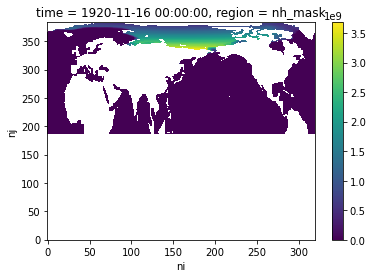

In [32]:
#just test that it worked properly
data_masked_area.sel(region='nh_mask').isel(member_id=0,time=10).plot()

In [34]:
# Get regional totals by summing over both spatial dimensions

# also convert to km2 or km3 depending on the input variable
if var_in == 'aice':
    factor = 1e6
    longname = 'regional total ice area'
    units = 'km^2'
else:
    factor = 1e9
    longname = 'regional total ice volume'
    units = 'km^3'


data_total = (data_masked_area.sum(dim='nj').sum(dim='ni'))/factor

In [35]:
#check the output here!
data_total.sel(region='nh_mask',member_id=0).values

array([13162954.44936438, 13886855.2785012 , 14223579.20505382, ...,
          71720.25357001,   629954.65750232,  3932776.6341499 ])

### Actually load the data now

Before, all the calculations were "lazy" version

In [36]:
%%time
## slow step
data_total.load()

CPU times: user 17.1 s, sys: 5.81 s, total: 22.9 s
Wall time: 26.4 s


<xarray.DataArray (member_id: 4, time: 2160, region: 1)>
array([[[1.31629544e+07],
        [1.38868553e+07],
        [1.42235792e+07],
        ...,
        [7.17202536e+04],
        [6.29954658e+05],
        [3.93277663e+06]],

       [[1.31709192e+07],
        [1.38809063e+07],
        [1.40831955e+07],
        ...,
        [1.30925816e+04],
        [2.65967939e+05],
        [3.62460265e+06]],

       [[1.31494573e+07],
        [1.39421588e+07],
        [1.41846539e+07],
        ...,
        [1.31913377e+04],
        [3.30882012e+05],
        [4.09685421e+06]],

       [[1.31709192e+07],
        [1.38809063e+07],
        [1.40831955e+07],
        ...,
        [3.89708994e+04],
        [4.24943035e+05],
        [3.41390729e+06]]])
Coordinates:
  * time     (time) object 1920-01-16 12:00:00 ... 2099-12-16 12:00:00
  * region   (region) <U7 'nh_mask'
Dimensions without coordinates: member_id

In [37]:
# assign member_id as coordinate array
data_total['member_id']=data_total.member_id.values

In [38]:
data_total.coords

Coordinates:
  * time       (time) object 1920-01-16 12:00:00 ... 2099-12-16 12:00:00
  * region     (region) <U7 'nh_mask'
  * member_id  (member_id) int64 0 1 2 3

### Save the timeseries

In [39]:
fout = 'LESSMELT_aicetot_nh_1920-2100'

ds_save = data_total.isel(region=0)

In [40]:
ds_to_save = xr.Dataset({'aice_monthly': (['member_id','time'], ds_save.data)},
                        coords={'time':(['time'],ds_save.time.values),
                                'member_id':(['member_id'],ds_save.member_id.values),},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [41]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:       (member_id: 4, time: 2160)
Coordinates:
  * time          (time) object 1920-01-16 12:00:00 ... 2099-12-16 12:00:00
  * member_id     (member_id) int64 0 1 2 3
Data variables:
    aice_monthly  (member_id, time) float64 1.316e+07 1.389e+07 ... 3.414e+06
Attributes:
    Author:    Alice DuVivier
    units:     km^2
    longname:  regional total ice area

In [42]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file